In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import pandas
from lightkurve.lightcurve import LightCurve
from pandas import read_csv
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
import batman
from ldtk import (LDPSetCreator,BoxcarFilter)
from ldtk.filters import kepler

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [3]:
candidates = read_csv('Data/toi-plus-2019-03-28.csv')
tic_id = candidates['tic_id']
Tmag = candidates['Tmag']
print(len(Tmag))

FileNotFoundError: File b'Data/toi-plus-2019-03-28.csv' does not exist

In [ ]:
TESS_rms = []
for i in range(len(tic_id)):
    lcf = lk.search_lightcurvefile('TIC {}'.format(tic_id[i])).download_all()
    lc = lcf[0].PDCSAP_FLUX.remove_outliers(sigma=5).flatten(break_tolerance=50).normalize()
    time_range = (np.amax(lc.time)-np.amin(lc.time))*24.0*60.0
    min_per_exp = time_range/len(lc.flux)
    #print(i)
    N = 10.0/min_per_exp
    LC = lc.bin(binsize=int(N))
    rms = np.std(LC.flux)
    TESS_rms.append(rms)

In [ ]:
data = Table([TESS_rms, Tmag], names=['TESS_rms', 'Tmag'])
ascii.write(data, 'tess_rms.dat')

In [6]:
data = pandas.read_csv('Data/TESS/TIC_305048087_Data1.csv')

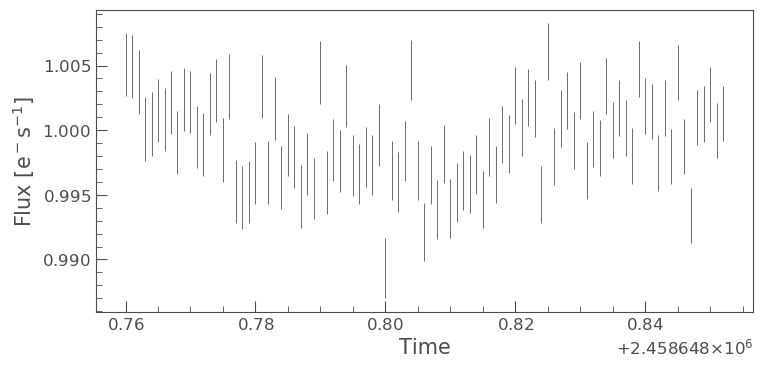

In [7]:
flux = data['rel_flux_T1']
lco_flux = flux/np.median(flux[50:])
lco_error = data['rel_flux_err_T1']/np.median(flux[50:])
lco_times = data['JD_UTC']
LCO_lc = LightCurve(time = lco_times, flux = lco_flux, flux_err = lco_error)

LCO_lc.errorbar(normalize=False)

In [15]:
time_range = (np.amax(LCO_lc.time)-np.amin(LCO_lc.time))*24.0*60.0
min_per_exp = time_range/len(flux)
N = 10.0/min_per_exp

print(N)
print(min_per_exp)

1.4039855045175489
1.42451613180099


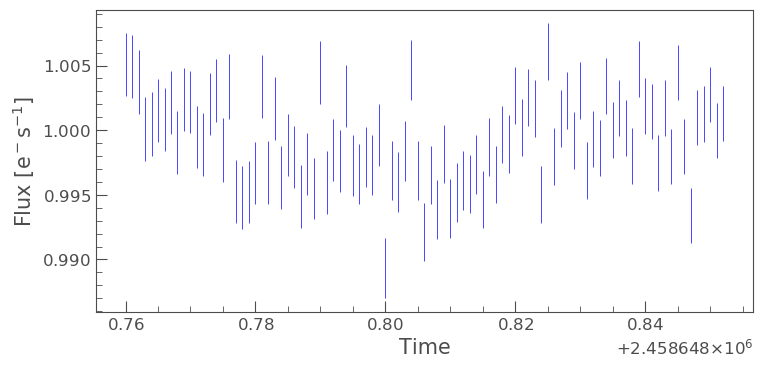

In [16]:
LC = LCO_lc.remove_outliers(sigma=5).bin(binsize=int(N))
LC.errorbar(color='blue',normalize=False)

In [52]:
print('length',len(LC.flux))
rms = np.std(LC.flux[8:])
print('rms',rms)
mean = np.mean(LC.flux[8:])
print('mean',mean)

length 13
rms 0.0005848405293765666
mean 1.0004651856566098


In [53]:
fluxes = LC.flux[8:]
errors = LC.flux_err[8:]

In [54]:
err = rms/np.sqrt(2*(len(fluxes)-1))
print(err)

0.00020677235211745022


In [40]:
star_teff = 3318.0
star_g = 4.96
star_met = 0.0

In [41]:
def Limb_Dark(Teff=star_teff,Terr=100,log_g=star_g,g_err=0.1,met=star_met,met_err=0.01):
    
    filters = [kepler]

    sc = LDPSetCreator(filters=filters,
                   teff=[Teff,Terr],
                   logg=[log_g, g_err],
                   z=[met, met_err])
    
    ps = sc.create_profiles(nsamples=500)
    qc,qe = ps.coeffs_qd(do_mc=True)
    
    LD_coeff = qc
    
    return LD_coeff

In [44]:
LD_coeff = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met)
LD = [LD_coeff[0][0],LD_coeff[0][1]]

In [72]:
def BATMAN(Baseline = 1.0, # units are whatever your flux units come in
           Rp = 0.07,
           P = 5.077,
           a = 28.14,
           b = 0.6,
           t0 = 0,
           t = None):
            
    params = batman.TransitParams()
    params.t0 = t0                       # time of inferior conjunction ()
    params.per = P                       # period in hours
    params.rp = Rp                       # planet radius (in units of stellar radii)
    params.a = a                         # semi-major axis (in units of stellar radii)
    params.inc = np.arccos(b/a)*180/np.pi   # orbital inclination (in degrees)
    params.ecc = 0.                      # eccentricity
    params.w = 90.                       # longitude of periastron (in degrees)
    params.u = LD                        # limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       # limb darkening model
        
    m = batman.TransitModel(params, t)   # initializes model
    
    flux = m.light_curve(params)*Baseline   # calculates light curve
    
    return flux

In [73]:
times = np.linspace(-0.1,0.1,300)
model_flux = BATMAN(t = times)

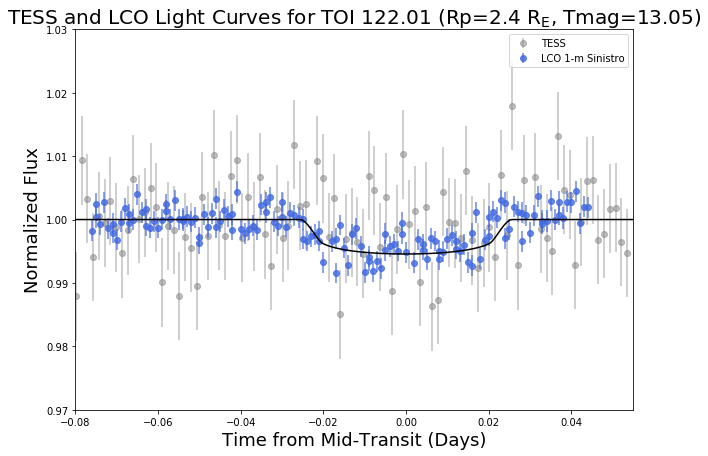

In [75]:
plt.figure(figsize=(10,7))
#lc.errorbar(lc.time,alpha=0.5,zorder=-1000,label='TESS')
plt.errorbar(lc.time-1329.121491,lc.flux,yerr=lc.flux_err,alpha=0.5,zorder=-1000,
             label='TESS',fmt='o',color='gray')
plt.errorbar(LCO_lc.time-(2458425.604),LCO_lc.flux,yerr=LCO_lc.flux_err,fmt='o',
             alpha=0.8,label='LCO 1-m Sinistro',color='royalblue')
plt.plot(times,model_flux,zorder=100,color='k')
plt.xlim(-0.08,0.055)
plt.ylim(0.97,1.03)
plt.title(r'TESS and LCO Light Curves for TOI 122.01 (Rp=2.4 R$_{\rm{E}}$, Tmag=13.05)',
         fontsize=20)
plt.legend()
plt.xlabel('Time from Mid-Transit (Days)',fontsize=18)
plt.ylabel('Normalized Flux',fontsize=18)
plt.savefig('Curve_Comparison.pdf')
plt.show()